## Data Loading

In [1]:
import h5py
import torch

path = "/home/cmu/anthony/MP-Neural-PDE-Solvers/data/CE_train_E1.h5"
f = h5py.File(path, 'r')
data = f['train']
data.keys()

<KeysViewHDF5 ['alpha', 'beta', 'gamma', 'pde_250-100', 'pde_250-200', 'pde_250-40', 'pde_250-50']>

In [2]:
from common.utils import HDF5Dataset
from torch.utils.data import DataLoader

pde = 'CE'
experiment = 'E1'
train_string = f'data/{pde}_train_{experiment}.h5'
dataset = HDF5Dataset(train_string, pde=pde, mode='train')
train_loader = DataLoader(dataset,
                        batch_size=2,
                        shuffle=False,
                        num_workers=4)
u_base, u_super, x, variables = next(iter(train_loader))
batch_size, tn, xn = u_base.shape

In [3]:
u_base[0][0][0:10]

tensor([0.4675, 0.5472, 0.6220, 0.6911, 0.7534, 0.8082, 0.8545, 0.8919, 0.9197,
        0.9376])

In [5]:
u_super[0][0][0:10]

tensor([0.4666, 0.5456, 0.6199, 0.6885, 0.7504, 0.8048, 0.8510, 0.8883, 0.9163,
        0.9345])

100%|██████████| 250/250 [00:00<00:00, 958.26it/s]


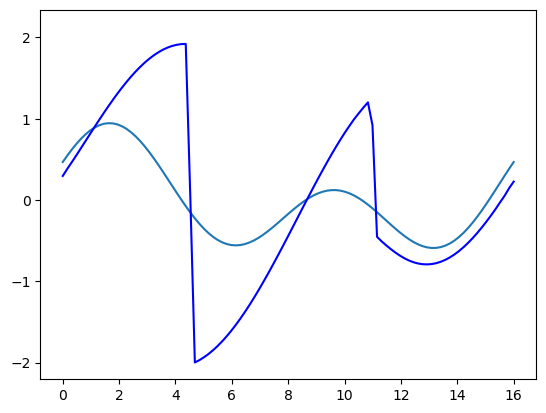

In [3]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from tqdm import tqdm

u_n = u_base[0]
x_n = x[0]

fig, ax = plt.subplots()

# Store the plot handle at each time step in the 'ims' list
ims = []
for i in tqdm(range(tn)):
    im = ax.plot(x_n, u_n[i],'b-', animated=True)
    if i == 0:
        ax.plot(x_n, u_n[i].squeeze())  # show an initial one first
    ax.plot
    ims.append([im[0]])

# Animate the plot
ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=1000)

writer = animation.PillowWriter(fps=15, bitrate=1800)
ani.save("assets/movie_E1_5_1.gif", writer=writer)

## GPT Setup

In [50]:
from common.utils import HDF5Dataset
from torch.utils.data import DataLoader
from experiments.models_gpt import GPT

pde = 'CE'
experiment = 'E1'
train_string = f'data/{pde}_train_{experiment}.h5'
dataset = HDF5Dataset(train_string, pde=pde, mode='train')
train_loader = DataLoader(dataset,
                        batch_size=2,
                        shuffle=True,
                        num_workers=4)

config = {"batch_size" : 2, # if gradient_accumulation_steps > 1, this is the micro-batch size
        "n_x": 100, 
        "block_size" : 250, # max sequence length for predicting next timestep. Sequence length can be shorter.
        "n_layer" : 3, 
        "n_head" : 8,
        "n_embd" : 256,
        "n_gnn": 100,
        "dropout" : 0.0, # for pretraining 0 is good, for finetuning try 0.1+
        "bias" : False # do we use bias inside LayerNorm and Linear layers?
}

model = GPT(config)
u_base, u_super, x, variables = next(iter(train_loader))
out = model(u_base[:, :250, :])

number of parameters: 2.48M


In [51]:
out2 = model(u_base[:, :100, :])

In [54]:
torch.allclose(out[:, :100, :], out2[:, :100, :])

True

## GNN Setup

In [27]:
from common.utils import HDF5Dataset
from torch.utils.data import DataLoader
from experiments.models_gpt import GPT
from common.utils import GraphCreator
from equations.PDEs import *
import random
from experiments.models_gnn import MP_PDE_Solver

pde = 'CE'
experiment = 'E1'
train_string = f'data/{pde}_train_{experiment}.h5'
dataset = HDF5Dataset(train_string, pde=pde, mode='train')
loader = DataLoader(dataset,
                        batch_size=2,
                        shuffle=True,
                        num_workers=4)

u_base, u_super, x, variables = next(iter(loader))

base_resolution = (250, 100)
pde = CE()
pde.tmin = dataset.tmin
pde.tmax = dataset.tmax
pde.grid_size = base_resolution
pde.dt = dataset.dt
graph_creator = GraphCreator(pde=pde,
                            neighbors=2,
                            time_window=20,
                            t_resolution=base_resolution[0],
                            x_resolution=base_resolution[1])

unrolling = [r for r in range(2 + 1)]
unrolled_graphs = 1
steps = [t for t in range(graph_creator.tw,
                            graph_creator.t_res - graph_creator.tw - (graph_creator.tw * unrolled_graphs) + 1)]
random_steps = random.choices(steps, k=2)
data, labels = graph_creator.create_data(u_super, random_steps)
data_gpt = u_super

config = {"batch_size" : 2, # if gradient_accumulation_steps > 1, this is the micro-batch size
        "n_x": 100, 
        "block_size" : 250, # max sequence length for predicting next timestep. Sequence length can be shorter.
        "n_layer" : 3, 
        "n_head" : 8,
        "n_embd" : 256,
        "n_gnn": 100,
        "dropout" : 0.0, # for pretraining 0 is good, for finetuning try 0.1+
        "bias" : False # do we use bias inside LayerNorm and Linear layers?
}

model_gpt = GPT(config)
embeddings = model_gpt(data_gpt)
graph = graph_creator.create_graph(data, embeddings, labels, x, variables, random_steps)

eq_variables = {}
model = MP_PDE_Solver(pde=pde,
                        time_window=graph_creator.tw,
                        eq_variables=eq_variables)

pred = model(graph)

number of GPT parameters: 2.48M


In [35]:
_, newlabels = graph_creator.create_data(u_super, newsteps)
olde = torch.clone(graph.e)
oldx = torch.clone(graph.x)
print(torch.allclose(labels, newlabels))
graph = graph_creator.create_next_graph(graph, pred, embeddings, newlabels, newsteps)

False


In [38]:
import torch
torch.cuda.is_available()

/home/cmu/anaconda3/envs/torch2/lib/python3.11/site-packages/torch/cuda/__init__.py:138: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at /opt/conda/conda-bld/pytorch_1695392026823/work/c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


False

## Training Setup

In [1]:
from common.utils import HDF5Dataset
from torch.utils.data import DataLoader
from experiments.models_gpt import GPT
from common.utils import GraphCreator
from equations.PDEs import *
import random
from experiments.models_gnn import MP_PDE_Solver
import wandb
from experiments.train_helper import *
from datetime import datetime
import torch_geometric

def train(gnn_config: dict,
          pde: PDE,
          epoch: int,
          model_gnn: torch.nn.Module,
          optimizer_gnn: torch.optim,
          loader: DataLoader,
          graph_creator: GraphCreator,
          criterion: torch.nn.modules.loss,
          model_gpt: torch.nn.Module = None,
          optimizer_gpt: torch.optim = None,
          scheduler_gpt: torch.optim.lr_scheduler = None,
          device: torch.cuda.device="cpu") -> None:
    """
    Training loop.
    Loop is over the mini-batches and for every batch we pick a random timestep.
    This is done for the number of timesteps in our training sample, which covers a whole episode.
    Args:
        args (argparse): command line inputs
        pde (PDE): PDE at hand [CE, WE, ...]
        model (torch.nn.Module): neural network PDE solver
        optimizer (torch.optim): optimizer used for training
        loader (DataLoader): training dataloader
        graph_creator (GraphCreator): helper object to handle graph data
        criterion (torch.nn.modules.loss): criterion for training
        device (torch.cuda.device): device (cpu/gpu)
    Returns:
        None
    """
    print(f'Starting epoch {epoch}...')
    if(use_gpt):
        model_gpt.train()
    model_gnn.train()

    max_unrolling = epoch if epoch <= gnn_config["unrolling"] else gnn_config["unrolling"]
    unrolling = [r for r in range(max_unrolling + 1)]

    # Loop over every epoch as often as the number of timesteps in one trajectory.
    # Since the starting point is randomly drawn, this in expectation has every possible starting point/sample combination of the training data.
    # Therefore in expectation the whole available training information is covered.
    for i in range(graph_creator.t_res):
        losses = training_loop(model_gnn, unrolling, gnn_config["batch_size"], optimizer_gnn, loader, graph_creator, criterion, model_gpt, optimizer_gpt, scheduler_gpt, device)
        print(f'Training Loss (progress: {i / graph_creator.t_res:.2f}): {torch.mean(losses)}')
        wandb.log({
        "train/loss": torch.mean(losses),
        })

def test(gnn_config: dict,
         pde: PDE,
         model_gnn: torch.nn.Module,
         loader: DataLoader,
         graph_creator: GraphCreator,
         criterion: torch.nn.modules.loss,
         model_gpt: torch.nn.Module = None,
         device: torch.cuda.device="cpu") -> torch.Tensor:
    """
    Test routine
    Both step wise and unrolled forward losses are computed
    and compared against low resolution solvers
    step wise = loss for one neural network forward pass at certain timepoints
    unrolled forward loss = unrolling of the whole trajectory
    Args:
        args (argparse): command line inputs
        pde (PDE): PDE at hand [CE, WE, ...]
        model (torch.nn.Module): neural network PDE solver
        loader (DataLoader): dataloader [valid, test]
        graph_creator (GraphCreator): helper object to handle graph data
        criterion (torch.nn.modules.loss): criterion for training
        device (torch.cuda.device): device (cpu/gpu)
    Returns:
        torch.Tensor: unrolled forward loss
    """
    model_gnn.eval()
    if(use_gpt):
        model_gpt.eval()

   # first we check the losses for different timesteps (one forward prediction array!)
    steps = [t for t in range(graph_creator.tw, graph_creator.t_res-graph_creator.tw + 1)]
    losses = test_timestep_losses(model=model_gnn,
                                  steps=steps,
                                  batch_size=gnn_config["batch_size"],
                                  loader=loader,
                                  graph_creator=graph_creator,
                                  criterion=criterion,
                                  gpt=model_gpt,
                                  device=device)

    # next we test the unrolled losses
    losses = test_unrolled_losses(model=model_gnn,
                                  steps=steps,
                                  batch_size=gnn_config["batch_size"],
                                  nr_gt_steps=2,
                                  nx_base_resolution=gnn_config["base_resolution"][1],
                                  loader=loader,
                                  graph_creator=graph_creator,
                                  criterion=criterion,
                                  gpt= model_gpt,
                                  device=device)

    return torch.mean(losses)


gpt_config = {
        ## GPT Config 
        "use_gpt": True,
        "max_iters": 20,
        "batch_size" : 16, # if gradient_accumulation_steps > 1, this is the micro-batch size
        "n_x": 100, 
        "block_size" : 250, # max sequence length for predicting next timestep. Sequence length can be shorter.
        "n_layer" : 3, 
        "n_head" : 8,
        "n_embd" : 128,
        "n_gnn": 100,
        "dropout" : 0.0, # for pretraining 0 is good, for finetuning try 0.1+
        "bias" : False, # do we use bias inside LayerNorm and Linear layers?
        "learning_rate": 1e-3,
        "pct_start": 0.1,
        "min_lr": 1e-4, # should be lr/10 ish
        "beta1" : 0.9,
        "beta2" : 0.95,
        "grad_clip": 1.0,
        "device": "cuda",

}

gnn_config = {
        ## GNN Config 

        "epochs": gpt_config["max_iters"],
        "batch_size": gpt_config["batch_size"],
        "n_x": gpt_config["n_x"],
        "experiment": "E1",
        "base_resolution": (250, 100),
        "super_resolution": (250, 200),
        "neighbors": 3,
        "time_window": 25,
        "lr": 1e-4,
        "lr_decay": 0.4,
        "unrolling": 1,
        "device": gpt_config["device"],
        "compile": False,
}

device = gpt_config["device"]
use_gpt = gpt_config["use_gpt"]

config = gpt_config | gnn_config

#run = wandb.init(
#    project="gpt-mp-pde-solver",
#    config=config)

## GNN Initialization
pde = CE(device=device)
train_string = f'data/{pde}_train_{gnn_config["experiment"]}.h5'
valid_string = f'data/{pde}_valid_{gnn_config["experiment"]}.h5'
test_string = f'data/{pde}_test_{gnn_config["experiment"]}.h5'

train_dataset = HDF5Dataset(train_string, pde=pde, mode='train', base_resolution=gnn_config["base_resolution"], super_resolution=gnn_config["super_resolution"])
train_loader = DataLoader(train_dataset,
                        batch_size=gnn_config["batch_size"],
                        shuffle=True,
                        num_workers=4)

valid_dataset = HDF5Dataset(valid_string, pde=pde, mode='valid', base_resolution=gnn_config["base_resolution"], super_resolution=gnn_config["super_resolution"])
valid_loader = DataLoader(valid_dataset,
                            batch_size=gnn_config["batch_size"],
                            shuffle=False,
                            num_workers=4)

test_dataset = HDF5Dataset(test_string, pde=pde, mode='test', base_resolution=gnn_config["base_resolution"], super_resolution=gnn_config["super_resolution"])
test_loader = DataLoader(test_dataset,
                            batch_size=gnn_config["batch_size"],
                            shuffle=False,
                            num_workers=4)

pde.tmin = train_dataset.tmin
pde.tmax = train_dataset.tmax
pde.grid_size = gnn_config["base_resolution"]
pde.dt = train_dataset.dt

eq_variables = {}
if gnn_config["experiment"] == 'E2':
        print('Beta parameter added to the GNN solver')
        eq_variables['beta'] = 0.2
elif gnn_config["experiment"]  == 'E3':
        print('Alpha, beta, and gamma parameter added to the GNN solver')
        eq_variables['alpha'] = 3.
        eq_variables['beta'] = 0.4
        eq_variables['gamma'] = 1.
elif (gnn_config["experiment"]  == 'WE3'):
        print('Boundary parameters added to the GNN solver')
        eq_variables['bc_left'] = 1
        eq_variables['bc_right'] = 1

graph_creator = GraphCreator(   pde=pde,
                                neighbors=gnn_config["neighbors"],
                                time_window=gnn_config["time_window"],
                                t_resolution=gnn_config["base_resolution"][0],
                                x_resolution=gnn_config["base_resolution"][1],
                                use_gpt=use_gpt).to(device)

model_gnn = MP_PDE_Solver(pde=pde,
                        time_window=graph_creator.tw,
                        eq_variables=eq_variables,
                        use_gpt=use_gpt)

model_parameters = filter(lambda p: p.requires_grad, model_gnn.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(f'Number of GNN parameters: {params}')
## GPT Initialization

if(use_gpt):
    model_gpt = GPT(gpt_config)
else:
    model_gpt = None
    optimizer_gpt = None
    scheduler_gpt = None

## Multi-GPU/Compile

if torch.cuda.device_count() > 1:
  print("Let's use", torch.cuda.device_count(), "GPUs!")
  model_gnn = nn.DataParallel(model_gnn)
  if(use_gpt):
    model_gpt = nn.DataParallel(model_gpt)

model_gnn = model_gnn.to(device)
optimizer_gnn = torch.optim.AdamW(model_gnn.parameters(), lr=gnn_config["lr"], fused=True)
scheduler_gnn = torch.optim.lr_scheduler.MultiStepLR(optimizer_gnn, milestones=[gnn_config["unrolling"], 5, 10, 15], gamma=gnn_config["lr_decay"])

if(use_gpt):
    model_gpt = model_gpt.to(device)
    optimizer_gpt = torch.optim.AdamW(model_gpt.parameters(), lr=gpt_config["min_lr"], betas=(gpt_config["beta1"], gpt_config["beta2"]), fused=True)
    scheduler_gpt = torch.optim.lr_scheduler.OneCycleLR(optimizer_gpt, max_lr=gpt_config["learning_rate"], steps_per_epoch=graph_creator.t_res * len(train_loader), epochs=gpt_config["max_iters"], pct_start=gpt_config["pct_start"], anneal_strategy='cos', final_div_factor=gpt_config["learning_rate"]/gpt_config["min_lr"])

if(gnn_config["compile"]):
    print("Compiling Models...")
    model_gnn = torch_geometric.compile(model_gnn, dynamic=True, fullgraph=True)
    if(use_gpt):
        model_gpt = torch.compile(model_gpt)

## Training
min_val_loss = 10e10
criterion = torch.nn.MSELoss(reduction="sum")
max_iters = gpt_config["max_iters"]

dateTimeObj = datetime.now()
timestring = f'{dateTimeObj.date().month}{dateTimeObj.date().day}{dateTimeObj.time().hour}{dateTimeObj.time().minute}'

save_path_gpt = f'models/GPT_{pde}_{gnn_config["experiment"]}_xresolution{gnn_config["base_resolution"][1]}-{gnn_config["super_resolution"][1]}_n{gnn_config["neighbors"]}_tw{gnn_config["time_window"]}_time{timestring}.pt'
save_path_gnn = f'models/GNN_{pde}_{gnn_config["experiment"]}_xresolution{gnn_config["base_resolution"][1]}-{gnn_config["super_resolution"][1]}_n{gnn_config["neighbors"]}_tw{gnn_config["time_window"]}_time{timestring}.pt'

save_path_log = f'logs/log_{pde}_{gnn_config["experiment"]}_xresolution{gnn_config["base_resolution"][1]}-{gnn_config["super_resolution"][1]}_n{gnn_config["neighbors"]}_tw{gnn_config["time_window"]}_time{timestring}.txt'

#with open(save_path_log, 'w') as f:
#    print(config, file=f)

Number of GNN parameters: 676345
number of GPT parameters: 0.65M


In [2]:
epoch = 1
if(use_gpt):
        model_gpt.train()
model_gnn.train()

max_unrolling = epoch if epoch <= gnn_config["unrolling"] else gnn_config["unrolling"]
unrolling = [r for r in range(max_unrolling + 1)]

In [3]:
u_base, u_super, x, variables = next(iter(train_loader))
batch_size = gnn_config["batch_size"]
optimizer_gnn.zero_grad()
if model_gpt is not None:
    optimizer_gpt.zero_grad()
# Randomly choose number of unrollings
unrolled_graphs = random.choice(unrolling)
steps = [t for t in range(graph_creator.tw,
                            graph_creator.t_res - graph_creator.tw - (graph_creator.tw * unrolled_graphs) + 1)]
# Randomly choose starting (time) point at the PDE solution manifold
random_steps = random.choices(steps, k=batch_size)
print(random_steps)
data, labels = graph_creator.create_data(u_super, random_steps)

if model_gpt is not None:
    data_gpt = u_super.to(device)
    embeddings = model_gpt(data_gpt)

if f'{model_gnn}' == 'GNN':
    graph = graph_creator.create_graph(data, labels, x, variables, random_steps).to(device)
else:
    data, labels = data.to(device), labels.to(device)

if model_gpt is not None:
    graph = graph_creator.add_embeddings(graph, embeddings, random_steps).to(device)

# Unrolling of the equation which serves as input at the current step
# This is the pushforward trick!!!
with torch.no_grad():
    for _ in range(unrolled_graphs):
        random_steps = [rs + graph_creator.tw for rs in random_steps]
        _, labels = graph_creator.create_data(u_super, random_steps)
        if f'{model_gnn}' == 'GNN':
            pred = model_gnn(graph)
            graph = graph_creator.create_next_graph(graph, pred, labels, random_steps).to(device)
        else:
            data = model_gnn(data)
            labels = labels.to(device)

if model_gpt is not None:
    graph = graph_creator.add_embeddings(graph, embeddings, random_steps).to(device)
    print(random_steps)

if f'{model_gnn}' == 'GNN':
    pred = model_gnn(graph)
    loss = criterion(pred, graph.y)
else:
    pred = model_gnn(data)
    loss = criterion(pred, labels)

loss = torch.sqrt(loss)
loss.backward()
optimizer_gnn.step()

grads_gnn = [
    param.grad.detach().flatten()
    for param in model_gnn.parameters()
    if param.grad is not None
]
norm_gnn = torch.cat(grads_gnn).norm()
print(norm_gnn)
#wandb.log({
#    "metrics/gradnorm_gnn": norm_gnn,
#})

if model_gpt is not None:
    optimizer_gpt.step()
    scheduler_gpt.step()
#    wandb.log({
#        "metrics/lr_gpt": scheduler_gpt.get_last_lr(),
#    })
    grads_gpt = [
        param.grad.detach().flatten()
        for param in model_gpt.parameters()
        if param.grad is not None
    ]
    norm_gpt = torch.cat(grads_gpt).norm()
    print(norm_gpt)
#    wandb.log({
#        "metrics/gradnorm_gpt": norm_gpt,
#    })

[172, 191, 140, 186, 185, 186, 70, 70, 46, 68, 63, 152, 52, 126, 26, 177]
torch.Size([250, 100])
torch.Size([250, 100])
torch.Size([250, 100])
torch.Size([250, 100])
torch.Size([250, 100])
torch.Size([250, 100])
torch.Size([250, 100])
torch.Size([250, 100])
torch.Size([250, 100])
torch.Size([250, 100])
torch.Size([250, 100])
torch.Size([250, 100])
torch.Size([250, 100])
torch.Size([250, 100])
torch.Size([250, 100])
torch.Size([250, 100])
torch.Size([250, 100])
torch.Size([250, 100])
torch.Size([250, 100])
torch.Size([250, 100])
torch.Size([250, 100])
torch.Size([250, 100])
torch.Size([250, 100])
torch.Size([250, 100])
torch.Size([250, 100])
torch.Size([250, 100])
torch.Size([250, 100])
torch.Size([250, 100])
torch.Size([250, 100])
torch.Size([250, 100])
torch.Size([250, 100])
torch.Size([250, 100])
[197, 216, 165, 211, 210, 211, 95, 95, 71, 93, 88, 177, 77, 151, 51, 202]
tensor(24.8914, device='cuda:0')
tensor(1.9195, device='cuda:0')


In [5]:
scheduler_gpt.get_last_lr()[0]

4.000000057831517e-05

In [5]:
embeddings.shape

torch.Size([16, 250, 100])

In [11]:
prediction

tensor([], device='cuda:0')

In [2]:
x = torch.arange(5000*128)
y = []
for i in range(5000*128):
    y.append(scheduler_gpt.get_last_lr())
    scheduler_gpt.step()

/home/cmu/anaconda3/envs/torch2/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


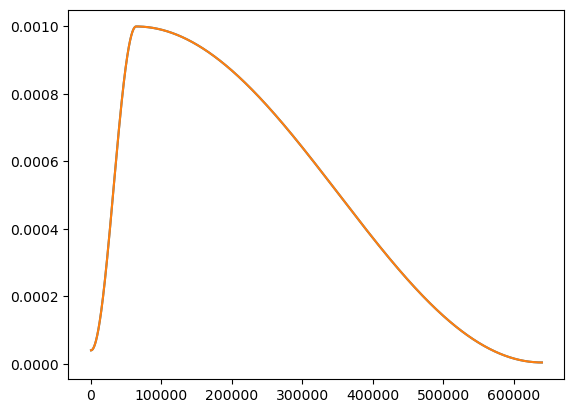

In [3]:
import matplotlib.pyplot as plt
plt.plot(x,y)

## Evaluation

In [1]:
## Load model
## Generate initial condition
## Propagate in time

from common.utils import HDF5Dataset
from torch.utils.data import DataLoader
from experiments.models_gpt import GPT
from common.utils import GraphCreator, process_dict, plot_traj, unroll_traj
from equations.PDEs import *
from experiments.models_gnn import MP_PDE_Solver
from experiments.train_helper import *

gpt_config = {
        ## GPT Config 
        "use_gpt": True,
        "max_iters": 20,
        "batch_size" : 16, # if gradient_accumulation_steps > 1, this is the micro-batch size
        "n_x": 100, 
        "block_size" : 250, # max sequence length for predicting next timestep. Sequence length can be shorter.
        "n_layer" : 3, 
        "n_head" : 8,
        "n_embd" : 128,
        "n_gnn": 100,
        "dropout" : 0.0, # for pretraining 0 is good, for finetuning try 0.1+
        "bias" : False, # do we use bias inside LayerNorm and Linear layers?
        "learning_rate": 1e-3,
        "warmup": 2000,
        "min_lr": 1e-4, # should be lr/10 ish
        "weight_decay": 1e-1,
        "beta1" : 0.9,
        "beta2" : 0.95,
        "grad_clip": 1.0,
        "decay_iters": 100,
        "device": "cuda",

}

gnn_config = {
        ## GNN Config 

        "epochs": gpt_config["max_iters"],
        "batch_size": gpt_config["batch_size"],
        "n_x": gpt_config["n_x"],
        "experiment": "E3",
        "base_resolution": (250, 100),
        "super_resolution": (250, 200),
        "neighbors": 3,
        "time_window": 25,
        "lr": 1e-4,
        "lr_decay": 0.4,
        "unrolling": 1,
        "device": gpt_config["device"],
}

config = gpt_config | gnn_config
use_gpt = gpt_config["use_gpt"]

## GPT Initialization
device = gpt_config["device"]

if(use_gpt):
    model_gpt = GPT(gpt_config)
    model_gpt.to(device)
else:
    model_gpt = None

## GNN Initialization
pde = CE(device=device)
train_string = f'data/{pde}_train_{gnn_config["experiment"]}.h5'
valid_string = f'data/{pde}_valid_{gnn_config["experiment"]}.h5'
test_string = f'data/{pde}_test_{gnn_config["experiment"]}.h5'

train_dataset = HDF5Dataset(train_string, pde=pde, mode='train', base_resolution=gnn_config["base_resolution"], super_resolution=gnn_config["super_resolution"])
train_loader = DataLoader(train_dataset,
                        batch_size=gnn_config["batch_size"],
                        shuffle=True,
                        num_workers=4)

valid_dataset = HDF5Dataset(valid_string, pde=pde, mode='valid', base_resolution=gnn_config["base_resolution"], super_resolution=gnn_config["super_resolution"])
valid_loader = DataLoader(valid_dataset,
                            batch_size=gnn_config["batch_size"],
                            shuffle=False,
                            num_workers=4)

test_dataset = HDF5Dataset(test_string, pde=pde, mode='test', base_resolution=gnn_config["base_resolution"], super_resolution=gnn_config["super_resolution"])
test_loader = DataLoader(test_dataset,
                            batch_size=gnn_config["batch_size"],
                            shuffle=False,
                            num_workers=4)

pde.tmin = train_dataset.tmin
pde.tmax = train_dataset.tmax
pde.grid_size = gnn_config["base_resolution"]
pde.dt = train_dataset.dt

eq_variables = {}
if gnn_config["experiment"] == 'E2':
        print('Beta parameter added to the GNN solver')
        eq_variables['beta'] = 0.2
elif gnn_config["experiment"]  == 'E3':
        print('Alpha, beta, and gamma parameter added to the GNN solver')
        eq_variables['alpha'] = 3.
        eq_variables['beta'] = 0.4
        eq_variables['gamma'] = 1.
elif (gnn_config["experiment"]  == 'WE3'):
        print('Boundary parameters added to the GNN solver')
        eq_variables['bc_left'] = 1
        eq_variables['bc_right'] = 1

graph_creator = GraphCreator(   pde=pde,
                                neighbors=gnn_config["neighbors"],
                                time_window=gnn_config["time_window"],
                                t_resolution=gnn_config["base_resolution"][0],
                                x_resolution=gnn_config["base_resolution"][1],
                                use_gpt=use_gpt).to(device)

model_gnn = MP_PDE_Solver(pde=pde,
                        time_window=graph_creator.tw,
                        eq_variables=eq_variables,
                        use_gpt=use_gpt).to(device)

model_parameters = filter(lambda p: p.requires_grad, model_gnn.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(f'Number of GNN parameters: {params}')

checkpoint_gnn = torch.load("models/good/GNN_E3_time1110137.pt")
checkpoint_gpt = torch.load("models/good/GPT_E3_time1110137.pt")

checkpoint_gnn = process_dict(checkpoint_gnn)
checkpoint_gpt = process_dict(checkpoint_gpt)

model_gnn.load_state_dict(checkpoint_gnn)
model_gnn.eval()

model_gpt.load_state_dict(checkpoint_gpt)
model_gpt.eval()

number of GPT parameters: 0.65M
Alpha, beta, and gamma parameter added to the GNN solver
Number of GNN parameters: 681337


GPT(
  (transformer): ModuleDict(
    (wte): Linear(in_features=100, out_features=128, bias=True)
    (wpe): Embedding(250, 128)
    (drop): Dropout(p=0.0, inplace=False)
    (h): ModuleList(
      (0-2): 3 x Block(
        (ln_1): LayerNorm()
        (attn): CausalSelfAttention(
          (c_attn): Linear(in_features=128, out_features=384, bias=False)
          (c_proj): Linear(in_features=128, out_features=128, bias=False)
          (attn_dropout): Dropout(p=0.0, inplace=False)
          (resid_dropout): Dropout(p=0.0, inplace=False)
        )
        (ln_2): LayerNorm()
        (mlp): MLP(
          (c_fc): Linear(in_features=128, out_features=512, bias=False)
          (gelu): GELU(approximate='none')
          (c_proj): Linear(in_features=512, out_features=128, bias=False)
          (dropout): Dropout(p=0.0, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm()
  )
  (lm_head): Linear(in_features=128, out_features=100, bias=False)
)

In [2]:
steps = [t for t in range(graph_creator.tw, graph_creator.t_res-graph_creator.tw + 1)]
criterion = torch.nn.MSELoss(reduction="sum")
losses = test_unrolled_losses(model_gnn=model_gnn,
                                  steps=steps,
                                  batch_size=gnn_config["batch_size"],
                                  nr_gt_steps=1,
                                  nx_base_resolution=100,
                                  loader=test_loader,
                                  graph_creator=graph_creator,
                                  criterion=criterion,
                                  model_gpt= model_gpt,
                                  device=device)

Unrolled forward losses 72.6197429010561
Unrolled forward base losses 4.326044156055098


## Visualizations

In [4]:
batch_size = gnn_config["batch_size"]
nr_gt_steps = 1

traj, traj_true = unroll_traj(test_loader, model_gnn, model_gpt, graph_creator, batch_size, device)

In [5]:
traj.shape[:100]

torch.Size([250, 100])

In [6]:
traj_true.shape

torch.Size([1, 250, 100])

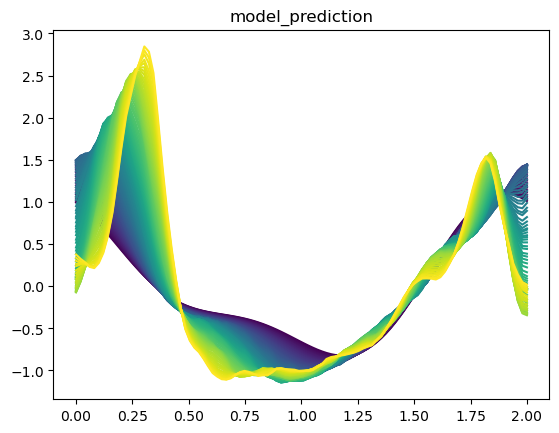

In [7]:
plot_traj(traj[:100].detach().cpu(), "model_prediction")

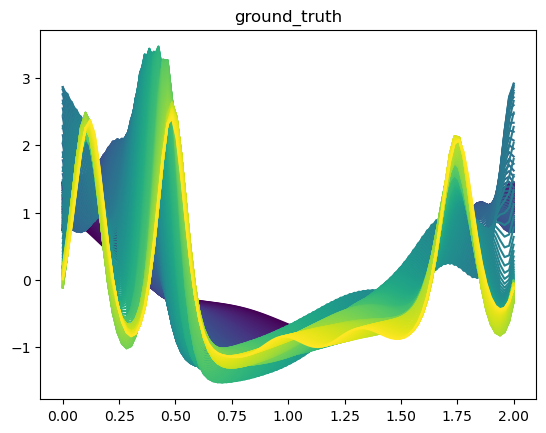

In [8]:
plot_traj(traj_true[0].detach().cpu(), "ground_truth")

## Embeddings

In [74]:
u_low = torch.Tensor()
u_high = torch.Tensor()

for (u_base, u_super, x, variables) in train_loader:
    if(variables['alpha']<.75 and variables['beta']<0.15 and variables['gamma']< 0.2):
        u_low = torch.cat((u_low, u_base), 0)
    if(variables['alpha']>5.5 and variables['beta']<0.15 and variables['gamma']< 0.2):
        u_high = torch.cat((u_high, u_base), 0)
emb_low = model_gpt(u_low.to(device))
emb_high = model_gpt(u_high.to(device))
emb_low = emb_low[:, 0, :]
emb_high = emb_high[:, 0, :]
emb_labels = torch.zeros(emb_low.shape[0] + emb_high.shape[0])
for i in range(len(emb_labels)):
    if(i >= emb_low.shape[0]):
        emb_labels[i]= 1
emb = torch.cat((emb_low, emb_high), 0)

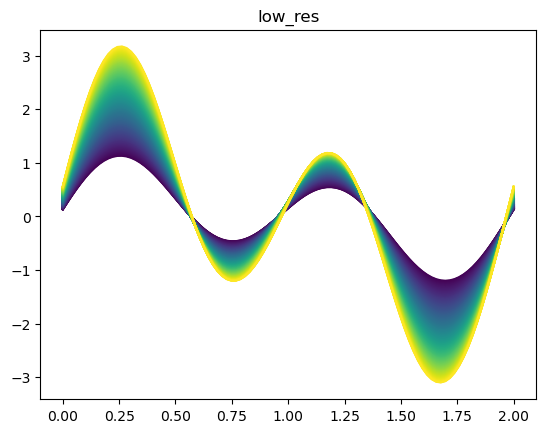

In [77]:
plot_traj(u_low[2].detach().cpu(), "low_res")

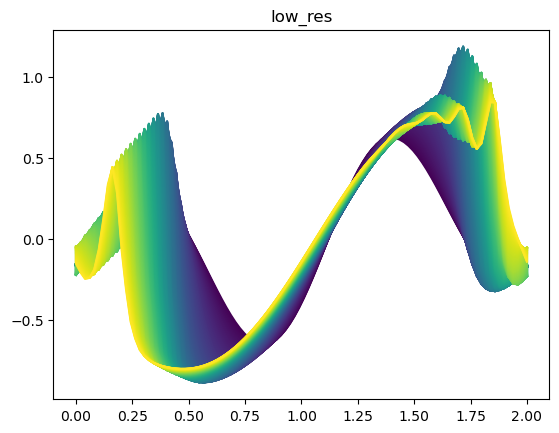

In [78]:
plot_traj(u_high[2].detach().cpu(), "low_res")

In [57]:
emb_low.shape

torch.Size([8, 100])

In [58]:
emb_high.shape

torch.Size([16, 100])

In [59]:
emb.shape

torch.Size([24, 100])

In [75]:
from sklearn.decomposition import PCA
import matplotlib as mpl
import matplotlib.pyplot as plt

emb_np = emb.detach().cpu().numpy()
pca = PCA(n_components = 2)
emb_low = pca.fit(emb_np).transform(emb_np)

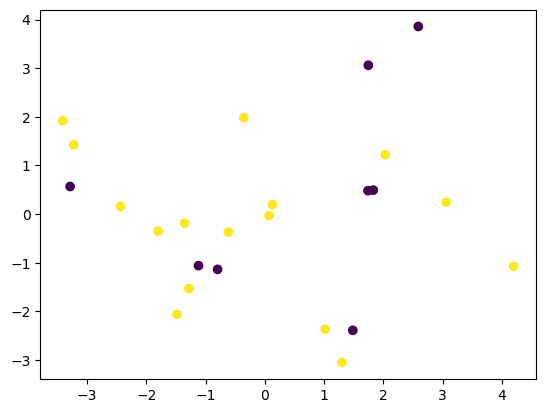

In [76]:
import matplotlib as mpl
import matplotlib.pyplot as plt
cmap = mpl.colormaps['viridis']
plt.scatter(emb_low[:, 0], emb_low[:,1], c=cmap(emb_labels))

## Curriculum Learning

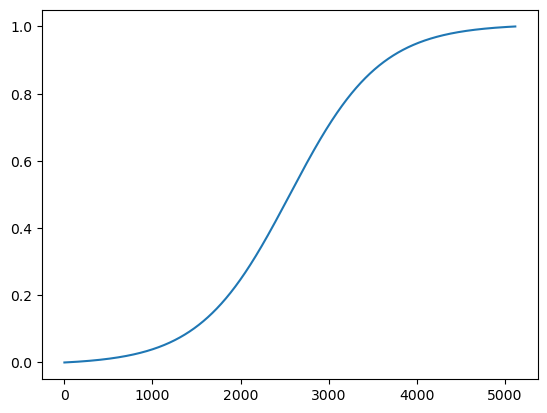

In [89]:
import matplotlib.pyplot as plt
total_epochs = 20*4096/16
delta = .2
epochs = torch.arange(total_epochs, dtype=torch.long)
p = []
for epoch in epochs:
    p.append(curriculum.get_prob(epoch))
plt.plot(epochs, p)

In [88]:
epoch

tensor(0.)

In [4]:
from common.utils import generate_gpt_data, Curriculum
total_epochs = 20*4096/16
delta = .2
curriculum = Curriculum(total_epochs, delta)
p = curriculum.get_prob(0)

u_base, u_super, x, variables = next(iter(train_loader))
cache = torch.ones_like(u_super)

In [25]:
steps = [100]*gnn_config["batch_size"]
data_gpt = generate_gpt_data(u_super, cache, steps, curriculum.get_prob(5000), graph_creator.tw)

In [26]:
data_gpt[0, :, 0]

tensor([-0.2083, -0.2098, -0.2113, -0.2129, -0.2144, -0.2159, -0.2174, -0.2189,
        -0.2204, -0.2219, -0.2234, -0.2249, -0.2263, -0.2278, -0.2293, -0.2307,
        -0.2322, -0.2336, -0.2351, -0.2365, -0.2379, -0.2393, -0.2408, -0.2422,
        -0.2436, -0.2450,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,
         1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,
         1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,
         1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,
         1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,
         1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,
         1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,
         1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,
         1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,
         1.0000,  1.0000,  1.0000,  1.00

In [40]:
u_base, u_super, x, variables = next(iter(train_loader))
mode = 'GNN'
batch_size = gnn_config["batch_size"]
criterion = torch.nn.MSELoss(reduction="sum")
losses = []
# Randomly choose number of unrollings
unrolled_graphs = 1
steps = [25, 150]

# Create cache of autoregressive predictions
cache = torch.clone(u_super).to(device)

# Initialize a counter for curriculum learning. Equal across batches, increases as the epoch and timestep increases
step_c = 0

for step in steps:

    same_steps = [step] * batch_size
    data, labels = graph_creator.create_data(u_super, same_steps)

    # Create first graph to propagate at t
    if mode == 'GNN':
        graph = graph_creator.create_graph(data, labels, x, variables, same_steps).to(device)
    else:
        data, labels = data.to(device), labels.to(device)
    
    #Create first data to generate embeddings at t
    if model_gpt is not None:
        curriculum_prob = torch.Tensor([1])
        print(curriculum_prob)
        data_gpt = generate_gpt_data(u_super, cache, same_steps, curriculum_prob, graph_creator.tw).to(device)
        print(torch.allclose(data_gpt[:, :25, :].cpu(), u_super[:, :25, :]))
        print(torch.allclose(data_gpt[:, 25:50, :].cpu(), u_super[:, 25:50, :]))
        print(torch.allclose(data_gpt[:, 50:75, :].cpu(), u_super[:, 50:75, :]))
        print(torch.allclose(data_gpt[:, 75:100, :].cpu(), u_super[:, 75:100, :]))
        print(torch.allclose(data_gpt[:, 100:150, :].cpu(), u_super[:, 100:150, :]))

    # Unrolling of the equation which serves as input at the current step
    # This is the pushforward trick!!!
    with torch.no_grad():
        for _ in range(unrolled_graphs):

            # Forward pass of GPT model to make an embedding at t. Adds embedding to graph
            if model_gpt is not None:
                embeddings = model_gpt(data_gpt)
                graph = graph_creator.add_embeddings(graph, embeddings, same_steps).to(device)

            # Increments steps by tw and creates ground truth for t+1
            same_steps = [rs + graph_creator.tw for rs in same_steps]
            _, labels = graph_creator.create_data(u_super, same_steps)

            if mode == 'GNN':
                # Makes a prediction for state at t+1 and creates new graph with predicted state at t+1 as input and true state at t+2 as label
                pred = model_gnn(graph)
                graph = graph_creator.create_next_graph(graph, pred, labels, same_steps).to(device)

                # Updates data for GPT model at t+1 and puts prediction into cache
                pred_tensor = graph2tensor(pred, batch_size, graph_creator.x_res)
                cache[:, same_steps[0]-graph_creator.tw:same_steps[0], :] = pred_tensor.to(device)
                data_gpt = update_gpt_data(data_gpt, pred_tensor, same_steps, graph_creator.tw).to(device)
            else:
                data = model_gnn(data)
                labels = labels.to(device)

    # Forward pass of GPT model to make an embedding at t+1. Adds embedding to graph
    if model_gpt is not None:
        embeddings = model_gpt(data_gpt)
        graph = graph_creator.add_embeddings(graph, embeddings, same_steps).to(device)

    # Makes a prediction for state at t+2 and computes loss with true state at t+2
    # Caches prediction to use for autoregression
    if mode == 'GNN':
        pred = model_gnn(graph)
        loss = criterion(pred, graph.y)
        pred_tensor = graph2tensor(pred, batch_size, graph_creator.x_res)
        cache[:, same_steps[0]: same_steps[0] + graph_creator.tw, :] = pred_tensor.to(device)
    else:
        pred = model_gnn(data)
        loss = criterion(pred, labels)
    # Backpropagation and stepping the GNN optimizer
    loss = torch.sqrt(loss)
    loss.backward()
    losses.append(loss.detach() / batch_size)
    
    # increment counter for curriculum
    stepc = step_c + 5000

losses = torch.stack(losses)

tensor([1.])
True
False
False
False
False
tensor([1.])
True
False
False
True
True


RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

In [37]:
torch.allclose(data_gpt[:, :75, :].cpu(), u_super[:, 50:75, :])

True

In [35]:
data_gpt[0, :, 0]

tensor([-0.1015, -0.1032, -0.1048, -0.1064, -0.1081, -0.1098, -0.1116, -0.1134,
        -0.1152, -0.1171, -0.1191, -0.1210, -0.1231, -0.1251, -0.1272, -0.1294,
        -0.1316, -0.1338, -0.1361, -0.1384, -0.1408, -0.1432, -0.1457, -0.1483,
        -0.1509, -0.1535, -0.1562, -0.1590, -0.1618, -0.1646, -0.1676, -0.1706,
        -0.1736, -0.1767, -0.1799, -0.1831, -0.1863, -0.1897, -0.1930, -0.1965,
        -0.1999, -0.2035, -0.2071, -0.2107, -0.2144, -0.2181, -0.2218, -0.2257,
        -0.2295, -0.2334, -0.2373, -0.2413, -0.2453, -0.2493, -0.2534, -0.2575,
        -0.2616, -0.2657, -0.2698, -0.2740, -0.2782, -0.2824, -0.2866, -0.2909,
        -0.2951, -0.2993, -0.3036, -0.3078, -0.3121, -0.3163, -0.3206, -0.3248,
        -0.3291, -0.3333, -0.3375, -0.3417, -0.3459, -0.3501, -0.3542, -0.3584,
        -0.3625, -0.3666, -0.3707, -0.3747, -0.3788, -0.3828, -0.3868, -0.3907,
        -0.3947, -0.3986, -0.4024, -0.4063, -0.4101, -0.4139, -0.4176, -0.4213,
        -0.4250, -0.4286, -0.4323, -0.43